In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
train_df = pd.read_parquet('data/train_dataset_hackaton2023_train.gzip')
test_df = pd.read_parquet('data/hackaton2023_test.gzip')

## Проверка типов

In [188]:
print(train_df.dtypes)
print('----')
print(test_df.dtypes)

customer_id                int64
date_diff_post           float64
buy_post                   int64
group_name                object
revenue                  float64
startdatetime     datetime64[us]
dish_name                 object
ownareaall_sqm           float64
format_name               object
dtype: object
----
customer_id                int64
group_name                object
revenue                  float64
startdatetime     datetime64[us]
dish_name                 object
ownareaall_sqm           float64
format_name               object
dtype: object


## Пропуски

In [189]:
print(train_df.isnull().sum())
print('---')
print(test_df.isnull().sum())

customer_id             0
date_diff_post    2468517
buy_post                0
group_name              0
revenue                 0
startdatetime           0
dish_name               0
ownareaall_sqm          0
format_name             0
dtype: int64
---
customer_id       0
group_name        0
revenue           0
startdatetime     0
dish_name         0
ownareaall_sqm    0
format_name       0
dtype: int64


In [190]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12129384 entries, 0 to 24261978
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   customer_id     int64         
 1   date_diff_post  float64       
 2   buy_post        int64         
 3   group_name      object        
 4   revenue         float64       
 5   startdatetime   datetime64[us]
 6   dish_name       object        
 7   ownareaall_sqm  float64       
 8   format_name     object        
dtypes: datetime64[us](1), float64(3), int64(2), object(3)
memory usage: 925.4+ MB


## Самое популярное блюдо по месяцам с учетом категории клиента

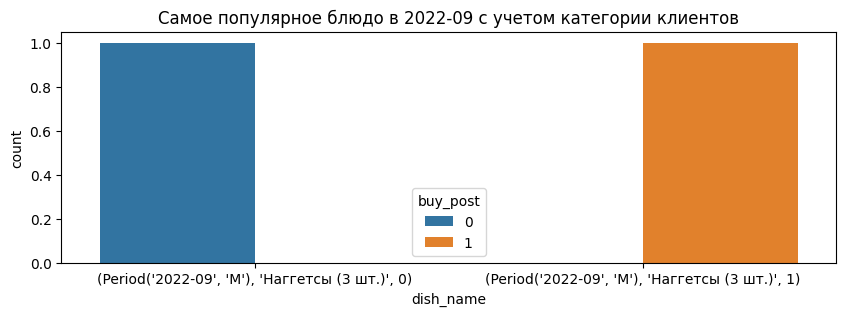

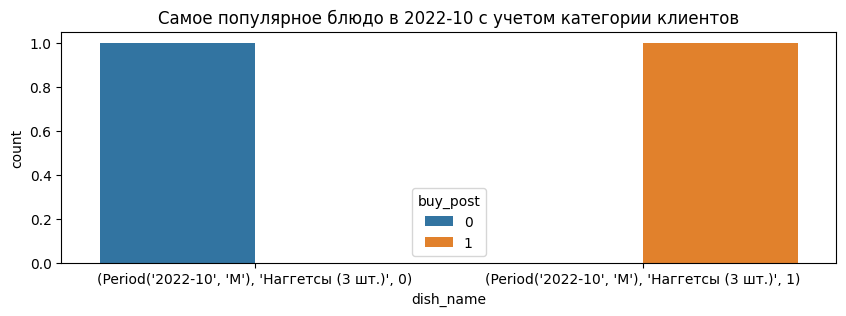

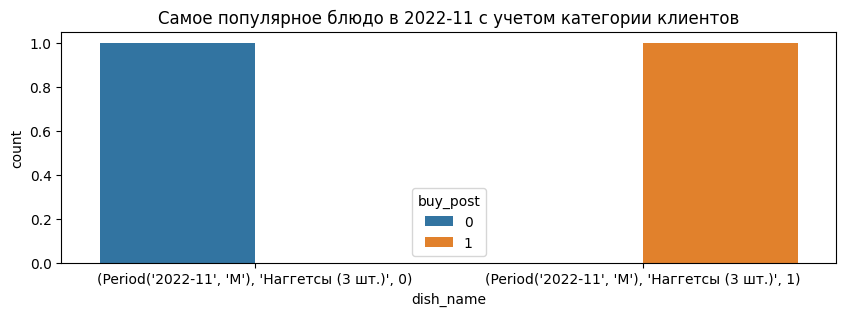

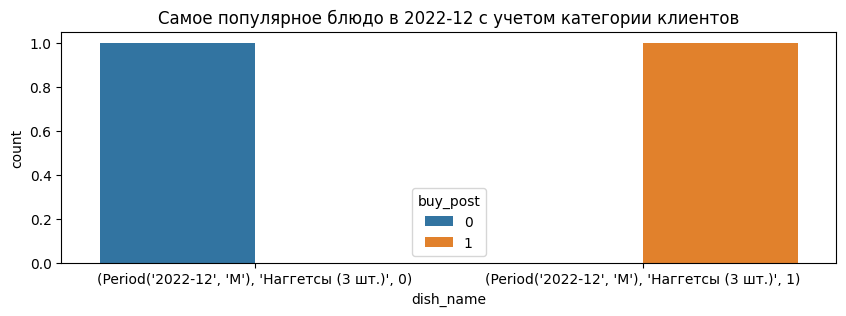

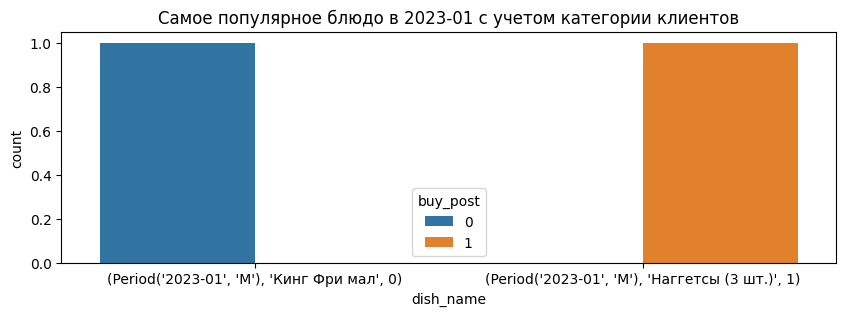

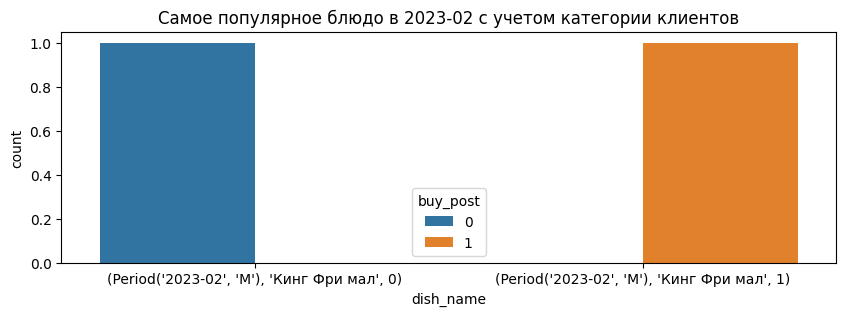

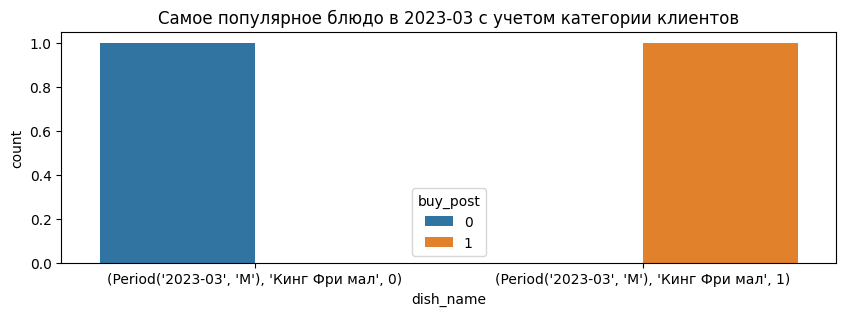

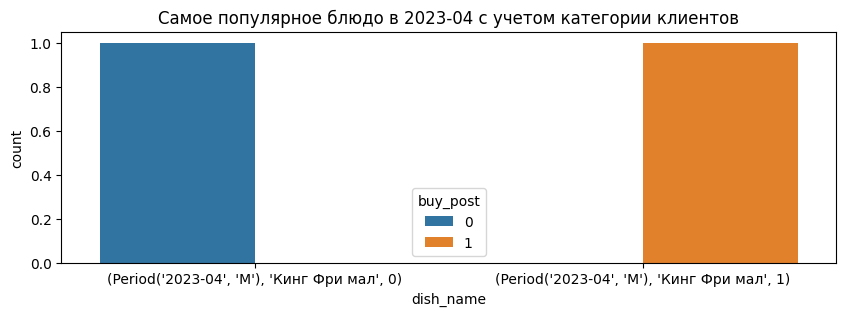

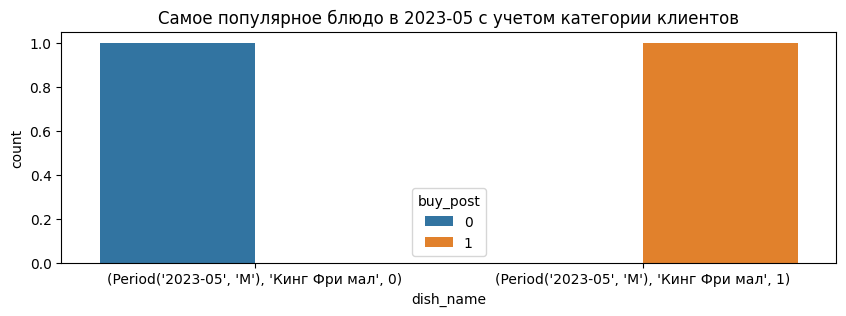

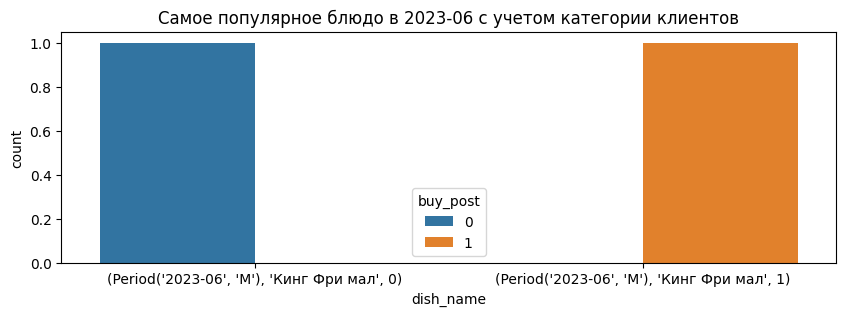

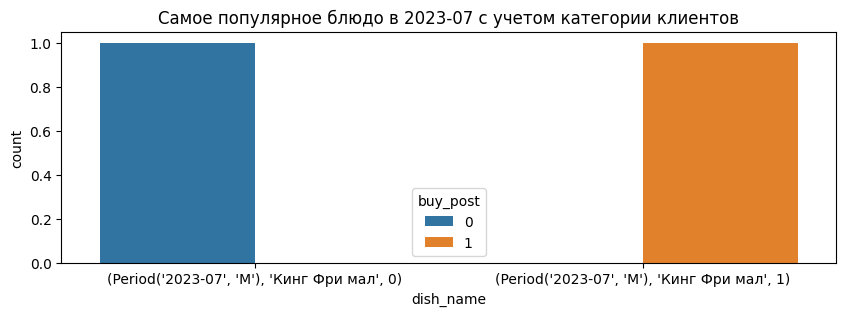

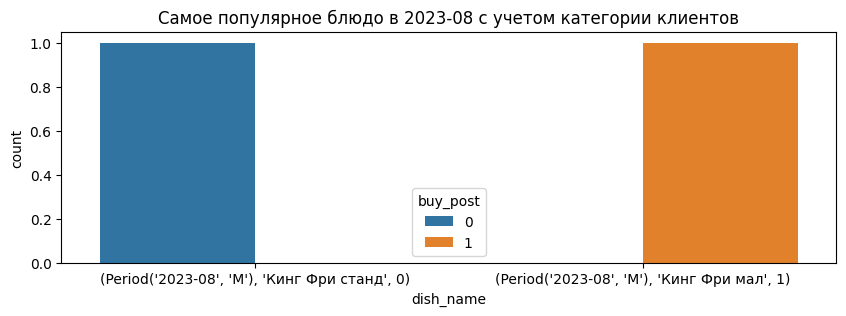

In [191]:
# Преобразование колонки startdatetime к типу данных datetime
train_df['startdatetime'] = pd.to_datetime(train_df['startdatetime'])

# Создание новой колонки month_year, которая содержит только месяц и год из startdatetime
train_df['month_year'] = train_df['startdatetime'].dt.to_period('M')

# Группировка данных по month_year, dish_name и buy_post, подсчет количества раз, когда каждое блюдо было заказано в каждом месяце и году
grouped = train_df.groupby(['month_year', 'dish_name', 'buy_post']).size()

# Нахождение самого популярного блюда для каждого месяца и года для каждой категории клиентов
most_popular_dishes = grouped.groupby(['month_year', 'buy_post']).idxmax()

# Создание DataFrame для хранения результатов
results = pd.DataFrame(most_popular_dishes, columns=['dish_name'])

# Разделение индекса на отдельные столбцы
results.reset_index(inplace=True)

# Создание отдельных графиков для каждого месяца и года
for month_year in results['month_year'].unique():
    subset = results[results['month_year'] == month_year]
    plt.figure(figsize=(10, 3))
    sns.countplot(x='dish_name', hue='buy_post', data=subset)
    plt.title(f'Самое популярное блюдо в {month_year} с учетом категории клиентов')
    plt.show()


## Откуда утекают клиенты

In [215]:
# Группировка данных по 'format_name' и 'buy_post', подсчет количества клиентов в каждой группе
grouped = train_df.groupby(['format_name', 'buy_post']).size()

# Выделение данных только для клиентов, которые ушли
churned = grouped[:, 0]

# Сортировка данных по убыванию для определения ресторанов с наибольшим количеством ушедших клиентов
churned_sorted = churned.sort_values(ascending=False)

print(churned_sorted)


format_name
Фудкорт без туалета                              973229
Отдельно стоящий с внешней зоной                 463865
Отдельно стоящий без внешней зоны                354990
Отдельно стоящий                                 327769
Фудкорт с туалетом                               243128
Отдельно стоящий без внешней зоны без туалета     57951
Отдельно стоящий без туалета                      31334
Отдельно стоящий с внешн.зоной без туалета        16251
dtype: int64


## Средний чек по ресторанам

In [216]:
# Группировка данных по 'customer_id', 'format_name', 'date' и 'buy_post', подсчет суммы 'revenue' в каждой группе
grouped = train_df.groupby(['customer_id', 'format_name', 'startdatetime', 'buy_post'])['revenue'].sum().reset_index()

# Группировка полученных данных по 'format_name' и 'buy_post', вычисление среднего значения 'revenue'
average_bill = grouped.groupby(['format_name', 'buy_post'])['revenue'].mean()

In [217]:
palette=['#6839cf', '#a0cf39']

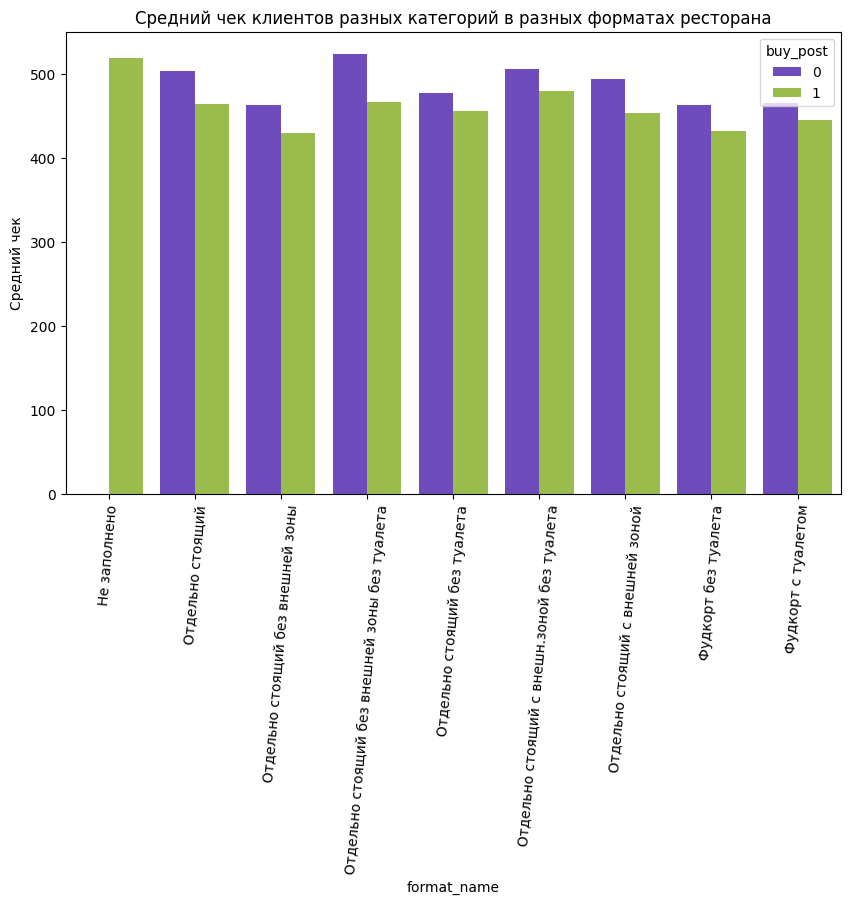

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

# Создание нового DataFrame для визуализации
average_bill_df = average_bill.reset_index()

# Создание графика
plt.figure(figsize=(10, 6))
sns.barplot(x='format_name', y='revenue', hue='buy_post', data=average_bill_df, palette=palette)
plt.title('Средний чек клиентов разных категорий в разных форматах ресторана')
plt.ylabel('Средний чек')
plt.xticks(rotation=85)  # Поворот названий ресторанов на 90 градусов
plt.show()

## Средний чек клиентов по месяцам

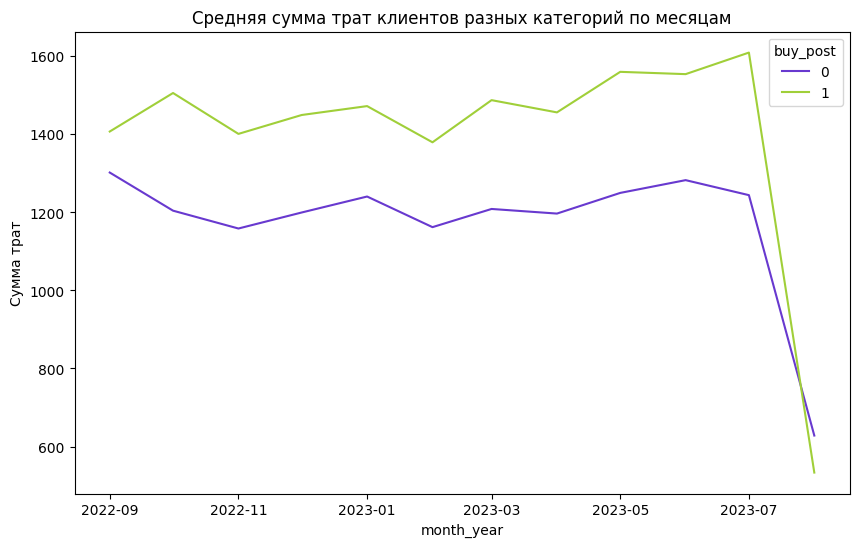

In [219]:
# Создание новой колонки month_year, которая содержит только месяц и год из startdatetime
train_df['month_year'] = train_df['startdatetime'].dt.to_period('M')

# Группировка данных по 'month_year', 'customer_id' и 'buy_post', подсчет суммы 'revenue' в каждой группе
grouped = train_df.groupby(['month_year', 'customer_id', 'buy_post'])['revenue'].sum().reset_index()

# Группировка полученных данных по 'month_year' и 'buy_post', вычисление среднего значения 'revenue'
average_bill = grouped.groupby(['month_year', 'buy_post'])['revenue'].mean().reset_index()

# Преобразование month_year обратно в формат даты
average_bill['month_year'] = average_bill['month_year'].dt.to_timestamp()

# Создание графика
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='revenue', hue='buy_post', data=average_bill, palette=palette)
plt.title('Средняя сумма трат клиентов разных категорий по месяцам')
plt.ylabel('Сумма трат')
plt.show()

## Самые популярные позиции в 'среднем' чеке

In [220]:
import pandas as pd

# Предполагается, что ваш исходный датафрейм называется df
# Группировка данных по customer_id и startdatetime
grouped_data = train_df.groupby(['customer_id', 'startdatetime'])

# Создание списка товаров для каждого чека
receipts = grouped_data['dish_name'].apply(list).reset_index(name='dishes')

# Опционально: добавление других полезных столбцов, например, общей выручки каждого чека
receipts['total_revenue'] = grouped_data['revenue'].sum().values

In [221]:
import pandas as pd

# Предполагается, что ваш исходный датафрейм называется df
# Группировка данных по customer_id и startdatetime
grouped_data = train_df.groupby(['customer_id', 'startdatetime'])

# Создание списка товаров для каждого чека и подсчет количества позиций
receipts = grouped_data['dish_name'].apply(list).reset_index(name='dishes')
receipts['items_count'] = receipts['dishes'].apply(len)

# Подсчет общей выручки, средней, максимальной и минимальной стоимости позиции в чеке
receipts['total_revenue'] = grouped_data['revenue'].sum().values
receipts['average_item_price'] = grouped_data['revenue'].mean().values
receipts['max_item_price'] = grouped_data['revenue'].max().values
receipts['min_item_price'] = grouped_data['revenue'].min().values

# Подсчет общего количества чеков для каждого клиента
#total_receipts_per_customer = train_df.groupby('customer_id').size().reset_index(name='total_receipts_')

# Объединение этой информации с основным датафреймом чеков
receipts = receipts.merge(total_receipts_per_customer, on='customer_id')

In [222]:
receipts.head()

,customer_id,startdatetime,dishes,items_count,total_revenue,average_item_price,max_item_price,min_item_price,total_receipts
0,29891,2022-12-05 12:03:58,"[Кинг Фри станд, Чикен Тар-Тар, Соус Сырный, Э...",4,389.97,97.4925,190.00,9.99,34
1,29891,2022-12-05 14:28:35,[Латте (СТАНД.)],1,119.99,119.9900,119.99,119.99,34
2,29891,2022-12-15 00:37:19,"[Чизбургер, Воппер Ролл]",2,269.99,134.9950,209.99,60.00,34
3,29891,2022-12-20 09:20:38,[ЧизБекон Чикен Гамбургер],1,144.97,144.9700,144.97,144.97,34
4,29891,2022-12-21 09:46:23,[Цезарь Кинг новый],1,184.96,184.9600,184.96,184.96,34


Также, по но месяцам

In [223]:
import pandas as pd

# Предполагается, что ваш исходный датафрейм называется df
# Добавление информации о месяце
train_df['month'] = train_df['startdatetime'].dt.month

# Группировка данных по customer_id и месяцу
grouped_by_month = train_df.groupby(['customer_id', 'month'])

# Подсчет статистик по каждому клиенту в каждом месяце
monthly_stats = grouped_by_month.agg(total_receipts_month=('revenue', 'size'),
                                     average_receipt_value=('revenue', 'mean'),
                                     total_monthly_revenue=('revenue', 'sum'),
                                     max_receipt_value=('revenue', 'max'),
                                     min_receipt_value=('revenue', 'min')).reset_index()

In [224]:
monthly_stats.head()

,customer_id,month,total_receipts_month,average_receipt_value,total_monthly_revenue,max_receipt_value,min_receipt_value
0,29891,1,9,109.098889,981.89,329.96,1.00
1,29891,2,1,439.980000,439.98,439.98,439.98
2,29891,12,24,152.728333,3665.48,319.95,1.00
3,30477,10,25,105.594000,2639.85,399.99,1.00
4,30477,11,36,84.326389,3035.75,299.98,0.39


сохраним в исходный как фичи

In [225]:
# Объединение исходного датафрейма с данными о чеках
train_df = train_df.merge(receipts, on=['customer_id', 'startdatetime'], how='left')

# Для объединения с месячными статистиками, сначала добавьте информацию о месяце в исходный датафрейм
train_df['month'] = train_df['startdatetime'].dt.month

# Теперь объедините с месячными статистиками
train_df = train_df.merge(monthly_stats, on=['customer_id', 'month'], how='left')

In [226]:
train_df.shape

(12129384, 23)

In [227]:
train_df.columns

Index(['customer_id', 'date_diff_post', 'buy_post', 'group_name', 'revenue',
       'startdatetime', 'dish_name', 'ownareaall_sqm', 'format_name',
       'month_year', 'month', 'dishes', 'items_count', 'total_revenue',
       'average_item_price', 'max_item_price', 'min_item_price',
       'total_receipts', 'total_receipts_month', 'average_receipt_value',
       'total_monthly_revenue', 'max_receipt_value', 'min_receipt_value'],
      dtype='object')

In [228]:
train_df.head()

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,month_year,...,total_revenue,average_item_price,max_item_price,min_item_price,total_receipts,total_receipts_month,average_receipt_value,total_monthly_revenue,max_receipt_value,min_receipt_value
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,2022-12,...,389.97,97.4925,190.00,9.99,34,24,152.728333,3665.48,319.95,1.0
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны,2022-12,...,389.97,97.4925,190.00,9.99,34,24,152.728333,3665.48,319.95,1.0
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны,2022-12,...,389.97,97.4925,190.00,9.99,34,24,152.728333,3665.48,319.95,1.0
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны,2022-12,...,389.97,97.4925,190.00,9.99,34,24,152.728333,3665.48,319.95,1.0
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны,2022-12,...,119.99,119.9900,119.99,119.99,34,24,152.728333,3665.48,319.95,1.0


## Чеки на клиента

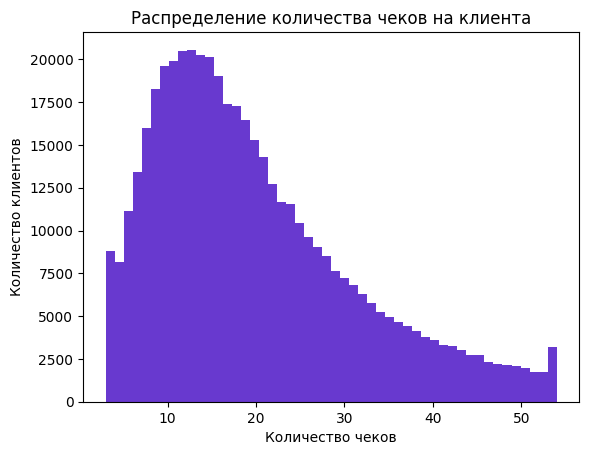

In [230]:
Q1 = train_df['customer_id'].value_counts().quantile(0.25)
Q3 = train_df['customer_id'].value_counts().quantile(0.75)
IQR = Q3 - Q1

filter = (train_df['customer_id'].value_counts() >= Q1 - 1.5 * IQR) & (train_df['customer_id'].value_counts() <= Q3 + 1.5 * IQR)

train_df['customer_id'].value_counts().loc[filter].plot(kind='hist', bins=50, title='Распределение количества чеков на клиента', color=palette[0])
plt.xlabel('Количество чеков')
plt.ylabel('Количество клиентов')
plt.show()

## Изменение общей выручки по месяцам

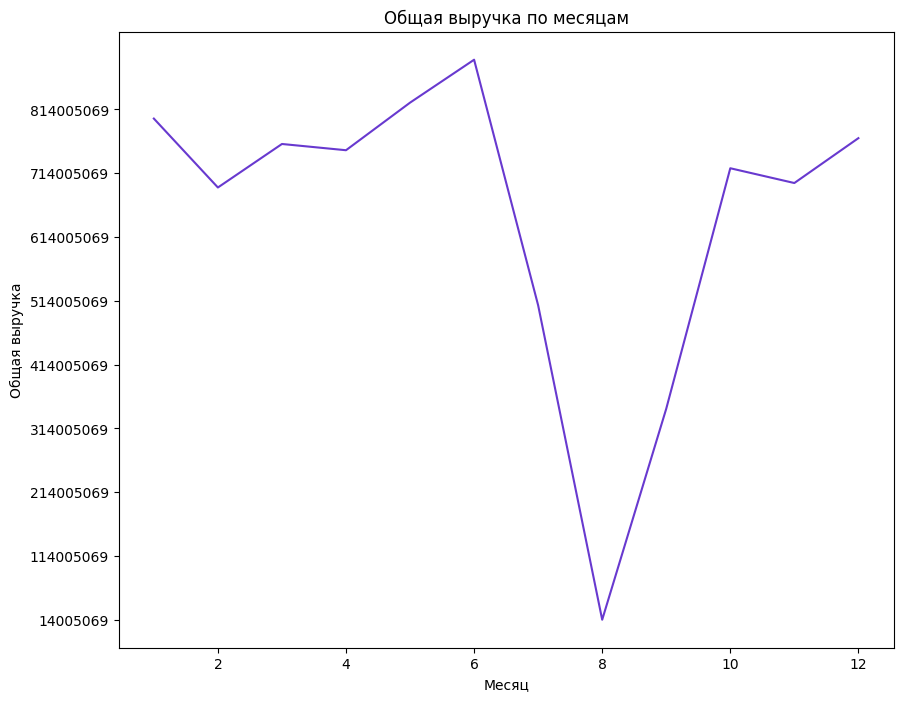

In [231]:
import numpy as np

monthly_revenue = train_df.groupby('month')['total_revenue'].sum()

plt.figure(figsize=(10,8))
plt.ticklabel_format(useOffset=False, style='plain') # отключаем научную нотацию

# определяем минимальное и максимальное значения для оси Y
y_min = monthly_revenue.min()
y_max = monthly_revenue.max()

# создаем массив значений с шагом, например, 10000000
yticks_values = np.arange(y_min, y_max, 100000000)

plt.yticks(yticks_values) # устанавливаем значения делений на оси Y

monthly_revenue.plot(kind='line', title='Общая выручка по месяцам', color=palette[0])
plt.xlabel('Месяц')
plt.ylabel('Общая выручка')
plt.show()

## boxplot средний чек

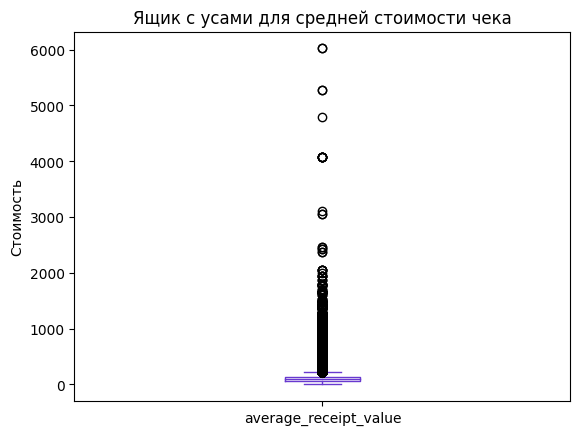

In [232]:
train_df['average_receipt_value'].plot(kind='box', title='Ящик с усами для средней стоимости чека', color=palette[0])
plt.ylabel('Стоимость')
plt.show()


## топ-10 популярных блюд

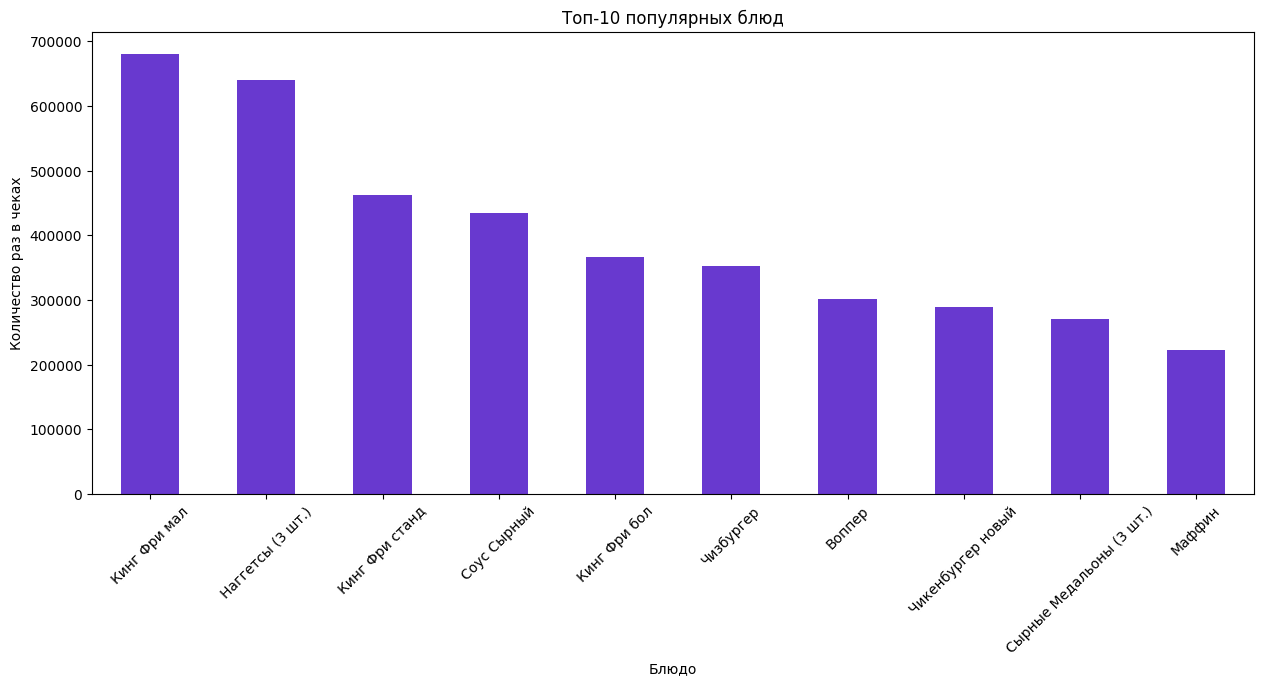

In [233]:
top_dishes = train_df['dish_name'].value_counts().head(10)

plt.figure(figsize=(15,6)) # устанавливаем размер фигуры
top_dishes.plot(kind='bar', title='Топ-10 популярных блюд', color=palette[0])
plt.xlabel('Блюдо')
plt.ylabel('Количество раз в чеках')
plt.xticks(rotation=45)
plt.show()

## выручка по разным форматам ресторанов

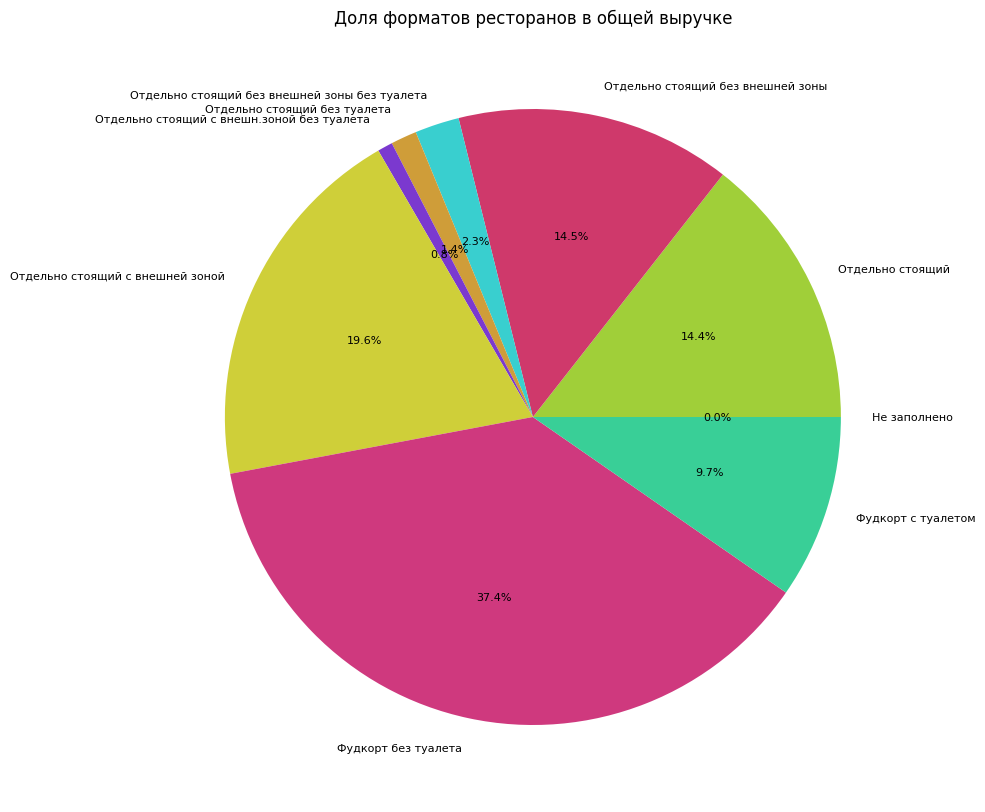

In [234]:
revenue_by_format = train_df.groupby('format_name')['total_revenue'].sum()
palette_pie = ['#6839cf', '#a0cf39', '#cf396b', '#39cfcf', '#cf9d39', '#7b39cf', '#cfcf39', '#cf397e', '#39cf97']

plt.figure(figsize=(10,10)) # увеличиваем размер графика
revenue_by_format.plot(kind='pie', title='Доля форматов ресторанов в общей выручке', autopct='%1.1f%%', textprops={'fontsize': 8}, colors=palette_pie) # уменьшаем размер шрифта
plt.ylabel('')
plt.show()


## позиции в чеке по времени

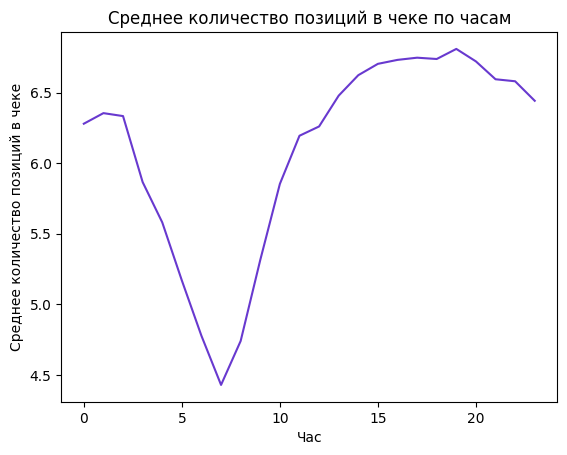

In [235]:
train_df.groupby(train_df['startdatetime'].dt.hour)['items_count'].mean().plot(kind='line', title='Среднее количество позиций в чеке по часам', color=palette[0])
plt.xlabel('Час')
plt.ylabel('Среднее количество позиций в чеке')
plt.show()

## Самое популярное время для покупок

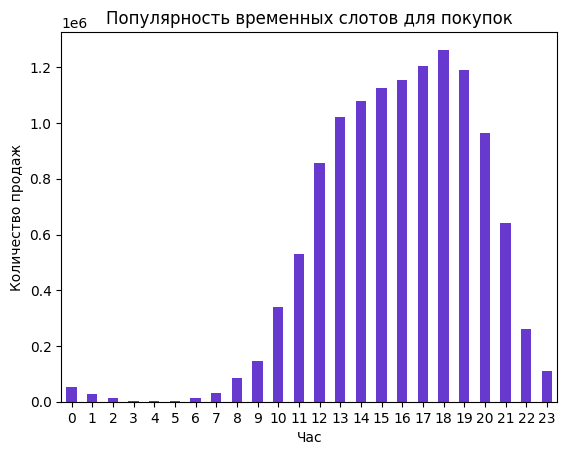

In [237]:
sales_by_hour = train_df.groupby(train_df['startdatetime'].dt.hour).size()

sales_by_hour.plot(kind='bar', title='Популярность временных слотов для покупок', color=palette[0])
plt.xlabel('Час')
plt.ylabel('Количество продаж')
plt.xticks(rotation=0)
plt.show()


## Дни недели/часы частота покупок

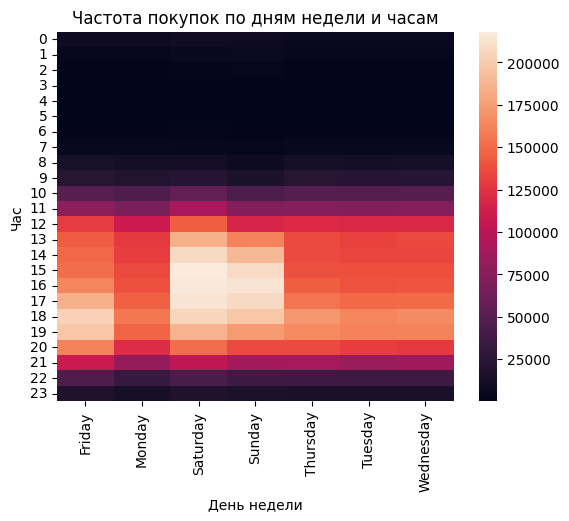

In [163]:
heatmap_df = train_df.pivot_table(index=train_df['startdatetime'].dt.hour, columns=train_df['startdatetime'].dt.day_name(), values='total_receipts', aggfunc='count')
sns.heatmap(heatmap_df)
plt.title('Частота покупок по дням недели и часам')
plt.xlabel('День недели')
plt.ylabel('Час')
plt.show()


## средняя стоимость позициив чеке

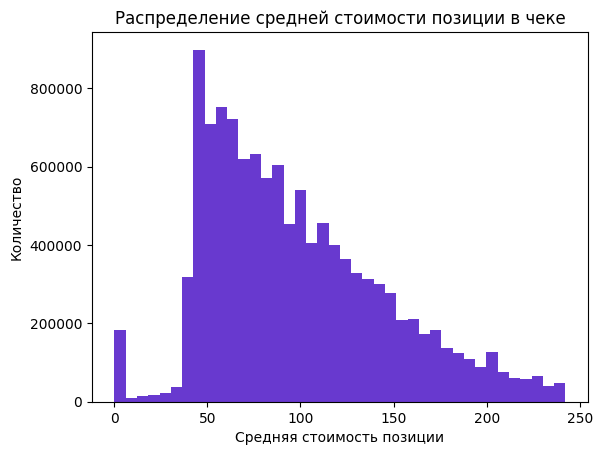

In [238]:
Q1 = train_df['average_item_price'].quantile(0.25)
Q3 = train_df['average_item_price'].quantile(0.75)
IQR = Q3 - Q1

filter = (train_df['average_item_price'] >= Q1 - 1.5 * IQR) & (train_df['average_item_price'] <= Q3 + 1.5 * IQR)

train_df['average_item_price'].loc[filter].plot(kind='hist', bins=40, title='Распределение средней стоимости позиции в чеке', color=palette[0])
plt.xlabel('Средняя стоимость позиции')
plt.ylabel('Количество')
plt.show()

## отток/удержание по месяцам

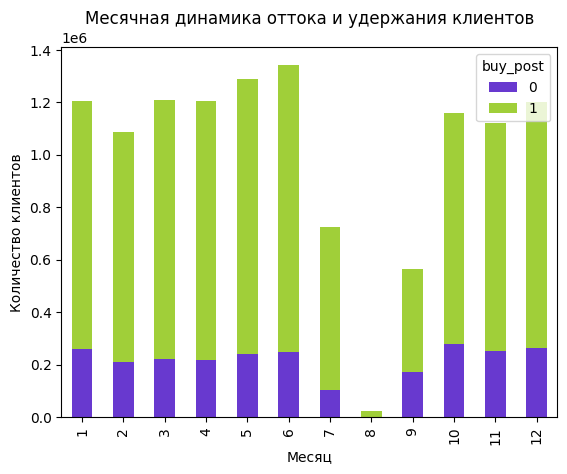

In [241]:
monthly_churn = train_df.groupby(['month', 'buy_post']).size().unstack()

monthly_churn.plot(kind='bar', stacked=True, title='Месячная динамика оттока и удержания клиентов', color=palette)
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.show()

## кумулят выручка

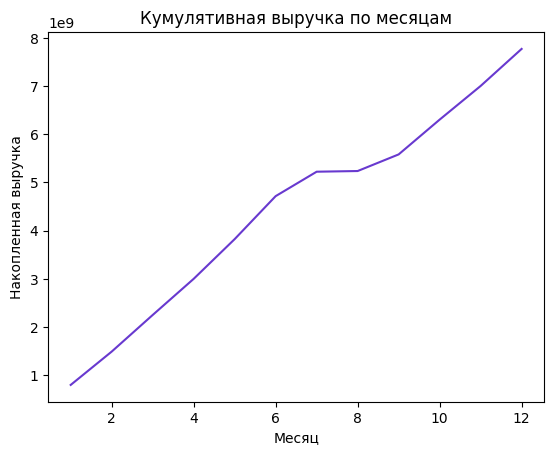

In [242]:
cumulative_revenue = train_df.groupby('month')['total_revenue'].sum().cumsum()

cumulative_revenue.plot(kind='line', title='Кумулятивная выручка по месяцам', color=palette[0])
plt.xlabel('Месяц')
plt.ylabel('Накопленная выручка')
plt.show()

## Выручка по дням недели

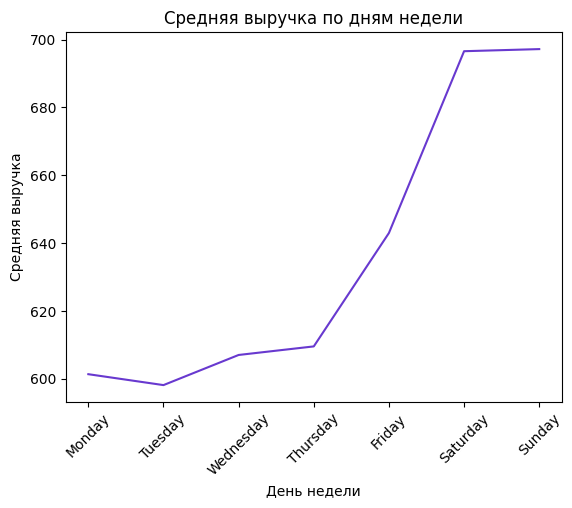

In [243]:
average_revenue_by_weekday = train_df.groupby(train_df['startdatetime'].dt.day_name())['total_revenue'].mean()
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
average_revenue_by_weekday = average_revenue_by_weekday.reindex(ordered_days)

average_revenue_by_weekday.plot(title='Средняя выручка по дням недели', color=palette)
plt.xlabel('День недели')
plt.ylabel('Средняя выручка')
plt.xticks(rotation=45)
plt.show()